In [1]:
using Distributions
using StatPlots
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
include("src/NGSIM.jl")

chmm_em! (generic function with 1 method)

In [3]:
K = 3
D = 2

# doesn't line up in format with NGSIM data (specifically, no time/frame aspect)
model = rand_chmm(K, D)
(X, Z, traj_ptr, traj_pairs_full) = rand_trajs(model, 
    T_range=100:1_000, N_pairs=500)
num_trajs = length(traj_ptr) - 1
num_obs = size(X, 2)

60676

In [4]:
# make fake data like NGSIM
r = zeros(num_obs)
c = zeros(num_obs)

T = 0
for (i, (i1, i2)) in enumerate(traj_pairs_full)
    s1 = traj_ptr[i1]
    e1 = traj_ptr[i1+1]-1
    
    s2 = traj_ptr[i2]
    e2 = traj_ptr[i2+1]-1
    
    @assert (e2-s2) == (e1-s1)
    dT = length(s2:e2)
    
    r[s1:e1] = T+(1:dT)
    r[s2:e2] = T+(1:dT)
    T += dT
    
    i = sub2ind((2, num_trajs), 1, i)
    c[s1:e1] = i
    c[s2:e2] = i+1
end

S = sparse(r, c, X[1,:])

@assert all(S.colptr .== traj_ptr)

num_pairs = round(Int, length(traj_pairs_full) / 4)
pairs = zeros(Int, 4, num_pairs)
for (i, ind) in enumerate(randperm(length(traj_pairs_full))[1:num_pairs])
    c1, c2 = traj_pairs_full[ind]
    pairs[1:2, i] = [c1, c2]
    pairs[3, i] = S.rowval[traj_ptr[c1]] + rand(1:10)
    pairs[4, i] = S.rowval[traj_ptr[c1+1]-1] - rand(1:10)
end

## EM

In [5]:
curr = chmm_from_data(X, K)
suff = ChmmSuffStats(curr)
;


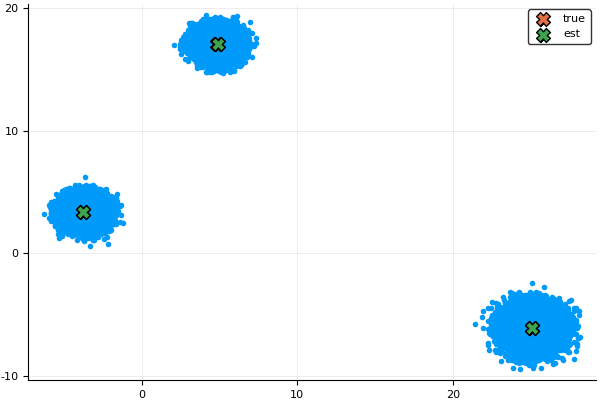

In [6]:
mhat = hcat(curr.μs...)'
m = hcat(model.μs...)'
scatter(X[1, :], X[2, :], label="", marker=(:circle, stroke(0)))
scatter!(m[:, 1], m[:, 2], marker=:X, ms=10, label="true")
scatter!(mhat[:,1], mhat[:, 2], marker=:X, ms=10, label="est")

In [7]:
(curr, log_like_hist) = chmm_em!(S, X, pairs, K, curr, suff; N_iters=100, print_every=10)
;

iteration     10:  -419028.011
iteration     20:  -418729.086
iteration     30:  -418685.544
iteration     40:  -418679.646
iteration     50:  -418678.872
iteration     60:  -418678.765



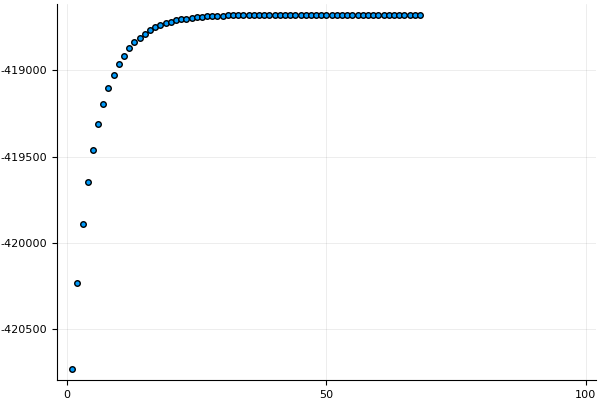

In [8]:
scatter(log_like_hist[2:end], legend=false)


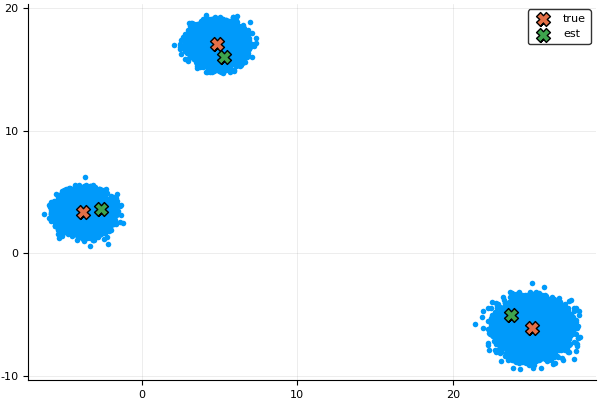

In [9]:
mhat = hcat(curr.μs...)'
m = hcat(model.μs...)'
scatter(X[1, :], X[2, :], label="", marker=(:circle, stroke(0)))
scatter!(m[:, 1], m[:, 2], marker=:X, ms=10, label="true")
scatter!(mhat[:,1], mhat[:, 2], marker=:X, ms=10, label="est")

# Analysis

In [10]:
true_to_est = empty(Int, K)
for i in 1:K
    m = model.μs[i]
    r = map(mm -> norm(m .- mm), curr.μs)
    true_to_est[i] = indmin(r)
end
true_to_est_full = vec(outer(true_to_est))
;

In [19]:
m_errs = [vec(model.μs[i] .- curr.μs[true_to_est[i]]) for i in 1:K]
hcat(m_errs ...)

2×3 Array{Float64,2}:
 -1.1424     1.34768  -0.446533
 -0.246475  -1.09202   1.03284 


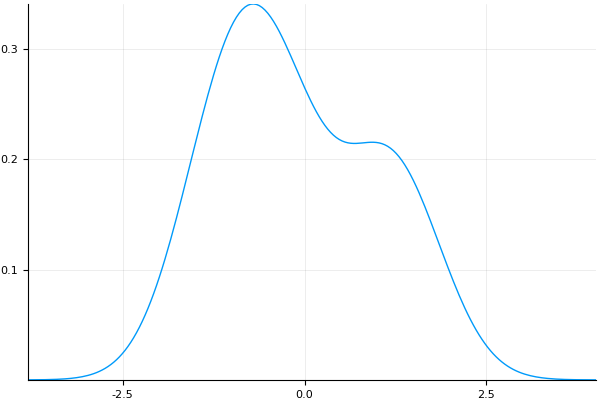

In [20]:
plot(vcat(m_errs...), seriestype=:density, legend=false)

In [12]:
P_true = copy(model.P)
P_hat = curr.P[true_to_est_full, true_to_est_full]
(mean(P_true .- P_hat), std(P_true .- P_hat))

(0.005514964476845649, 0.04507212339578667)


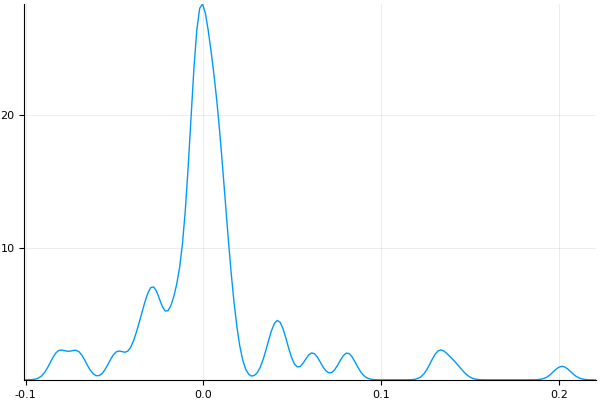

In [13]:
plot(vec(P_true .- P_hat), seriestype=:density, legend=false)

In [14]:
p0_true = copy(model.π0)
p0_hat = copy( curr.π0[true_to_est_full] )
(mean(p0_true .- p0_hat), std(p0_true .- p0_hat))

(0.009864107388309876, 0.13132055196147788)


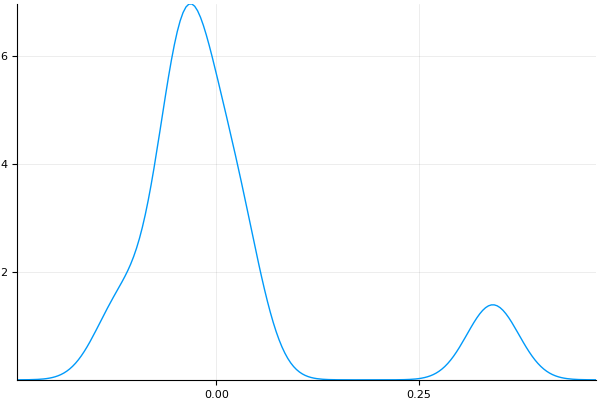

In [15]:
plot(vec(p0_true .- p0_hat), seriestype=:density, legend=false)

In [22]:
S_errs = [vec(model.Σs[i] .- curr.Σs[true_to_est[i]]) for i in 1:K]
[map(mean, S_errs) map(std, S_errs)]

3×2 Array{Float64,2}:
 -6.87638  13.6699
 -1.88897  27.9114
 -2.77792  16.7083


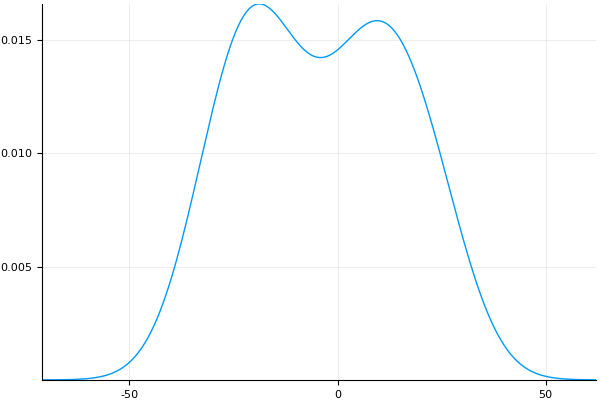

In [23]:
plot(vcat(S_errs...), seriestype=:density, legend=false)